# Denoising Autoencoderの実装

## Autoencoderとは？
## Autoencoder(自己符号化器)の核は,次元削減です．
### 伝播において，次元が小さくなった場合に，同様のデータを小さな情報量に圧縮する働きがあります．<br>具体的に，図１のような，単層の順伝播型ネットワークを考え，このネットワークを出力層で折り返し，入力層と出力層に同数のユニットを持つ図２のような２層のネットワークを作ります．この時，出力層の出力$\boldsymbol {x^{'}}$と入力$\boldsymbol x$がなるべく近くなるように２層の重みとバイアスを確率的勾配降下法によって調整します．

<img src="img/figure1.png" width=400>

<img src="img/figure2.png" width=600>

### $\boldsymbol x$に対して決まる$\boldsymbol y$のことを$\boldsymbol x$の符号とみなし，$\boldsymbol y=f(\boldsymbol W \boldsymbol x+\boldsymbol b)$を符号化(encode)，二番目の変換$\boldsymbol {x^{'}}=f^{'}(\boldsymbol {W^{'}} \boldsymbol y+\boldsymbol {b^{'}})$を復号化(decode)と呼びます．
## このような働きを持つニューラルネットワークをAutoencoderと呼びます．

## Denoising Autoencoderとは？
### Denoising Autoencoderとは訓練サンプル$\boldsymbol x$を確率的に変動させて，$\boldsymbol {\bar{x}}$とし，$\boldsymbol {\bar{x}}$によって得られた出力$\boldsymbol {x^{'}}(\boldsymbol {\bar{x}})$と元サンプル$\boldsymbol x$との誤差を最小にするように重みを設定する手法です．
### 例えば，$\boldsymbol x$に平均0,分散$\sigma^2$のガウス分布に従うランダムノイズ$$\delta x \sim N(0,\sigma^2 \boldsymbol I)$$を加算し$$\boldsymbol {\bar{x}}　=\boldsymbol x+\delta x $$とします．$\boldsymbol {\bar{x}}$を自己符号化器に入力し，符号化と，復号化を経て得られる出力$$\boldsymbol {x^{'}}(\boldsymbol {\bar{x}})=f^{'}(\boldsymbol {W^{'}} f(\boldsymbol W\boldsymbol {\bar{x}}+\boldsymbol b)+\boldsymbol {b^{'}})$$がノイズ加算前の元のサンプル$\boldsymbol x$に近くなるように学習を行います．
## Denoising Autoencoderの利点は，入力を再現できるだけでなく，ノイズを除去する能力もあることです．

### ライブラリのインポート

In [39]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from tensorflow.examples.tutorials.mnist import input_data

rng = np.random.RandomState(1234)
random_state = 42

###  1.MNISTデータセットの読み込み

In [40]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
mnist_X, mnist_y = mnist.train.images, mnist.train.labels
train_X, valid_X, train_y, valid_y = train_test_split(mnist_X, mnist_y, test_size=0.1, random_state=random_state)
print(train_y.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(49500, 10)


### 2.Autoencoderの実装

In [45]:
class Autoencoder:
    #重み，活性化関数の初期化
    def __init__(self, vis_dim, hid_dim, function=lambda x: x):
        self.W = tf.Variable(rng.uniform(low=-0.08, high=0.08, size=(vis_dim, hid_dim)).astype('float32'), name='W')
        self.a = tf.Variable(np.zeros(vis_dim).astype('float32'), name='a')
        self.b = tf.Variable(np.zeros(hid_dim).astype('float32'), name='b')
        self.function = function
        self.params = [self.W, self.a, self.b]
        
    #エンコーダ
    def encode(self, x):
        u = tf.matmul(x, self.W) + self.b
        return self.function(u)
    
    #デコーダ．重み関数はWの転置
    def decode(self, x):
        u = tf.matmul(x, tf.transpose(self.W)) + self.a
        return u
    
    #順伝播
    def f_prop(self, x):
        y = self.encode(x)
        return self.decode(y)
    #ノイズの生成
    def reconst(self, x, noise):
        tilde_x = x * noise
        reconst_x = self.f_prop(tilde_x)
        return reconst_x
    

### 3.モデルの構築

In [46]:
tf.reset_default_graph()
model = Autoencoder(train_X.shape[1], 500, tf.nn.sigmoid)
# パラメータ
# Learning rate (学習率)
lr = 0.1
# epoch数 （学習回数）
n_epoch = 10
# ミニバッチ学習における1バッチのデータ数
batchsize = 100


# 入力
x = tf.placeholder(tf.float32, [None, 784]) # 28*28次元 
noise = tf.placeholder(tf.float32, [None, 784], name='noise')

# ノイズを伴った出力
reconst_x = model.reconst(x, noise)

# 誤差関数
cost= tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=reconst_x), axis=1))

# SGD(Stochastic Gradient Descent : 確率的勾配降下法)で目的関数を最小化する
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)


### ノイズの与え方

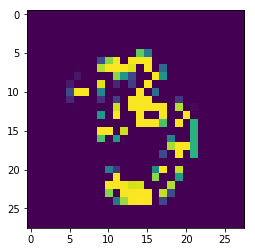

In [47]:
corrupt = rng.binomial(size=train_X[0:1].shape, n=1, p=1-0.5)
plt.imshow((train_X[0]*corrupt).reshape(28,28))
plt.show()

### 4. 学習

#### 4.1 Corruption level=0の場合

In [48]:
corruption_level = np.float32(0.0)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(train_X.shape[0])

        for i in range(0, train_X.shape[0], batchsize):
            # ミニバッチ分のデータを取ってくる
            X_batch = train_X[perm[i:i+batchsize]]
            _noise = rng.binomial(size=train_X[i:i+batchsize].shape, n=1, p=1-corruption_level)
            
            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, noise:_noise})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss / train_X.shape[0]
        print('Train loss %.5f | ' %(loss))
        weight_1 = sess.run(tf.transpose(model.W))

epoch 0 | Train loss 90.67939 | 
epoch 1 | Train loss 66.59492 | 
epoch 2 | Train loss 61.51000 | 
epoch 3 | Train loss 58.99969 | 
epoch 4 | Train loss 57.52602 | 
epoch 5 | Train loss 56.55618 | 
epoch 6 | Train loss 55.86876 | 
epoch 7 | Train loss 55.35007 | 
epoch 8 | Train loss 54.94395 | 
epoch 9 | Train loss 54.61418 | 


#### 重みの可視化

<img src="img/weight.png" width=400>

#### 上の図のように，第二層の各ユニットに入力される信号の重みを可視化しています．

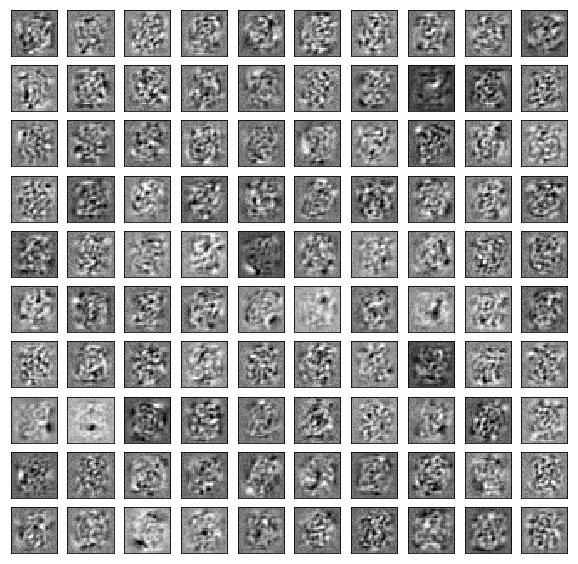

In [49]:
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight_1[i].reshape((28, 28)), cmap='gray')

#### 4.2 Corruption level=0.3の場合

In [25]:
corruption_level = np.float32(0.3)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(train_X.shape[0])

        for i in range(0, train_X.shape[0], batchsize):
            # ミニバッチ分のデータを取ってくる
            X_batch = train_X[perm[i:i+batchsize]]
            _noise = rng.binomial(size=train_X[i:i+batchsize].shape, n=1, p=1-corruption_level)
            
            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, noise:_noise})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss / train_X.shape[0]
        print('Train loss %.5f | ' %(loss))
        weight_2 = sess.run(tf.transpose(model.W))

epoch 0 | Train loss 104.06060 | 
epoch 1 | Train loss 81.15699 | 
epoch 2 | Train loss 77.27255 | 
epoch 3 | Train loss 75.29319 | 
epoch 4 | Train loss 74.02868 | 
epoch 5 | Train loss 72.96232 | 
epoch 6 | Train loss 72.06047 | 
epoch 7 | Train loss 71.32794 | 
epoch 8 | Train loss 70.61225 | 
epoch 9 | Train loss 70.07498 | 


#### 重みの可視化

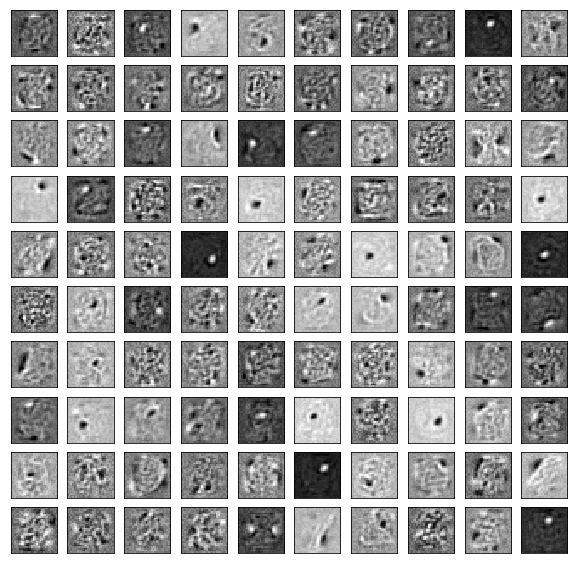

In [27]:
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(weight_2[i].reshape((28, 28)), cmap='gray')

### Corruption level=0.3の方が，特徴をよく捉えていることがわかります．

## Stacked Denoising Autoencoder (SdA) の実装

## 事前学習とは
### 事前学習とは，勾配消失問題を解消するために,重みの初期値に適当な値を与えることで学習をうまく行う手法のことです．<br>最も基本的なものに，自己符号化器を用いた手法があります．

## Stacked Autoencoder
### 図のような多層ネットワークに対して，１層ずつ複数の単層ネットワークに分割し，入力層から順に分割された単層ネットワークを自己符号化器とみなして教師なし学習を行い，各層のパラメータを決定します．このように単層のネットワークの自己符号化器を積み上げたものをStacked Autoencoder（積層自己符号化器）と呼びます．

<img src="img/pre_figure_all.png" width=400>

### 事前学習によって得られたネットワークの最上層に重みをランダムに初期化した層を一層以上追加し，目標とする教師あり学習を行います．

<img src="img/pre_figure_comp.png" width=600>

### 1. 各クラスの実装

#### autoencoder

In [50]:
class Autoencoder:
    def __init__(self, vis_dim, hid_dim, W, function=lambda x: x):
        self.W = W
        self.a = tf.Variable(np.zeros(vis_dim).astype('float32'), name='a')
        self.b = tf.Variable(np.zeros(hid_dim).astype('float32'), name='b')
        self.function = function
        self.params = [self.W, self.a, self.b]

    def encode(self, x):
        u = tf.matmul(x, self.W) + self.b
        return self.function(u)
    
    def decode(self, x):
        u = tf.matmul(x, tf.transpose(self.W)) + self.a
        return u

    def f_prop(self, x):
        y = self.encode(x)
        return self.decode(y)
    
    def reconst_error(self, x, noise):
        tilde_x = x * noise
        reconst_x = self.f_prop(tilde_x)
        error = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=reconst_x), axis=1))
        return error, reconst_x

#### 全結合層

In [51]:
class Dense:
    def __init__(self, in_dim, out_dim, function):
        self.W = tf.Variable(rng.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim)).astype('float32'), name='W')
        self.b = tf.Variable(np.zeros([out_dim]).astype('float32'))
        self.function = function
        #self.params = [self.W, self.b]
        
        self.ae = Autoencoder(in_dim, out_dim, self.W, self.function)

    def f_prop(self, x):
        u = tf.matmul(x, self.W) + self.b
        self.z = self.function(u)
        return self.z

    def pretrain(self, x, noise):
        cost, reconst_x = self.ae.reconst_error(x, noise)
        return cost, reconst_x

### 2. ネットワークの定義

In [52]:
layers = [
    Dense(784, 500, tf.nn.sigmoid),
    Dense(500, 500, tf.nn.sigmoid),
    Dense(500, 10, tf.nn.softmax)
]

### 3. 事前学習 (Pre-training)

In [54]:
X = np.copy(train_X)
lr = 0.1

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for l, layer in enumerate(layers[:-1]):
    corruption_level = np.float(0.3)
    batch_size = 100
    n_epochs = 10

    x = tf.placeholder(tf.float32)
    noise = tf.placeholder(tf.float32)

    cost, reconst_x = layer.pretrain(x, noise)
    encode = layer.f_prop(x)
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)



    
    for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")
        sum_loss = 0
        perm = np.random.permutation(X.shape[0])

        for i in range(0, X.shape[0], batchsize):
            X_batch = X[perm[i:i+batchsize]]
            _noise = rng.binomial(size=X[i:i+batchsize].shape, n=1, p=1-corruption_level)
            
            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, noise:_noise})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss / train_X.shape[0]
        print('Pretraining:: layer: %d, Epoch: %d, Error: %lf' % (l+1, epoch+1, loss))
    X = sess.run(encode, feed_dict={x: X})

epoch 0 | Pretraining:: layer: 1, Epoch: 1, Error: 104.097279
epoch 1 | Pretraining:: layer: 1, Epoch: 2, Error: 81.264416
epoch 2 | Pretraining:: layer: 1, Epoch: 3, Error: 77.378765
epoch 3 | Pretraining:: layer: 1, Epoch: 4, Error: 75.431728
epoch 4 | Pretraining:: layer: 1, Epoch: 5, Error: 74.036768
epoch 5 | Pretraining:: layer: 1, Epoch: 6, Error: 73.007906
epoch 6 | Pretraining:: layer: 1, Epoch: 7, Error: 72.193532
epoch 7 | Pretraining:: layer: 1, Epoch: 8, Error: 71.418534
epoch 8 | Pretraining:: layer: 1, Epoch: 9, Error: 70.713851
epoch 9 | Pretraining:: layer: 1, Epoch: 10, Error: 70.171440
epoch 0 | Pretraining:: layer: 2, Epoch: 1, Error: 173.669371
epoch 1 | Pretraining:: layer: 2, Epoch: 2, Error: 155.422183
epoch 2 | Pretraining:: layer: 2, Epoch: 3, Error: 152.439448
epoch 3 | Pretraining:: layer: 2, Epoch: 4, Error: 150.812758
epoch 4 | Pretraining:: layer: 2, Epoch: 5, Error: 149.667564
epoch 5 | Pretraining:: layer: 2, Epoch: 6, Error: 148.738264
epoch 6 | Pretra

### 4. 計算グラフ構築 & パラメータの更新設定

In [55]:
lr=0.1

x = tf.placeholder(tf.float32, [None, 784])
t = tf.placeholder(tf.float32, [None, 10])

def f_props(layers, x):
    for layer in layers:
        x = layer.f_prop(x)
    return x

y = f_props(layers, x)

cost = -tf.reduce_mean(tf.reduce_sum(t * tf.log(y), 1))
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)

valid = tf.argmax(y, 1)

### 5. 学習 (Fine-tuning)

In [56]:
n_epochs = 10
batch_size = 100

for epoch in range(n_epoch):
        print ('epoch %d | ' % epoch, end="")
        sum_loss = 0
        perm = np.random.permutation(train_X.shape[0])

        for i in range(0, train_X.shape[0], batchsize):
            X_batch = train_X[perm[i:i+batchsize]]
            t_batch = train_y[perm[i:i+batchsize]]
            
            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, t:t_batch})
            sum_loss += np.mean(loss) * X_batch.shape[0]

        loss = sum_loss / train_X.shape[0]
        pred_y, valid_cost = sess.run([valid, cost], feed_dict={x: valid_X, t: valid_y})
        print('EPOCH: %i, Validation cost: %.3f Validation F1: %.3f' % (epoch + 1, valid_cost, f1_score(np.argmax(valid_y, 1).astype('int32'), pred_y, average='macro')))


epoch 0 | EPOCH: 1, Validation cost: 0.292 Validation F1: 0.915
epoch 1 | EPOCH: 2, Validation cost: 0.243 Validation F1: 0.930
epoch 2 | EPOCH: 3, Validation cost: 0.214 Validation F1: 0.938
epoch 3 | EPOCH: 4, Validation cost: 0.196 Validation F1: 0.943
epoch 4 | EPOCH: 5, Validation cost: 0.184 Validation F1: 0.944
epoch 5 | EPOCH: 6, Validation cost: 0.174 Validation F1: 0.948
epoch 6 | EPOCH: 7, Validation cost: 0.163 Validation F1: 0.952
epoch 7 | EPOCH: 8, Validation cost: 0.157 Validation F1: 0.952
epoch 8 | EPOCH: 9, Validation cost: 0.150 Validation F1: 0.956
epoch 9 | EPOCH: 10, Validation cost: 0.144 Validation F1: 0.957


In [57]:
sess.close()